In [1]:
from tensorflow.keras import layers, models
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, Input
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import random  # Import random module
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Import missing functions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report
import cv2  # Import OpenCV for CLAHE
from tqdm import tqdm  # Import tqdm for progress bar
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
from io import BytesIO

In [2]:
# Path to your dataset directories
data_dir = r"C:\Users\sofea\OneDrive\Documents\DataSetStorage566\data"
train_dir = f"{data_dir}/training"
test_dir = f"{data_dir}/testing"

output_base = r"C:\Users\sofea\OneDrive\Documents\DataSetStorage566\preprocessed_dataset"
os.makedirs(output_base, exist_ok=True)



In [5]:
def clahe_preprocess(img_path):
    img = load_img(img_path)  # Load image
    img = img_to_array(img).astype(np.uint8)  # Convert to array
    
    # Convert to LAB and apply CLAHE
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    lab = cv2.merge([l, a, b])
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    
    return img

# Function to preprocess and save images
def preprocess_and_save(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    for class_name in os.listdir(input_dir):
        class_input_dir = os.path.join(input_dir, class_name)
        class_output_dir = os.path.join(output_dir, class_name)
        os.makedirs(class_output_dir, exist_ok=True)
        
        for img_name in tqdm(os.listdir(class_input_dir), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_input_dir, img_name)
            img_processed = clahe_preprocess(img_path)
            save_path = os.path.join(class_output_dir, img_name)
            cv2.imwrite(save_path, cv2.cvtColor(img_processed, cv2.COLOR_RGB2BGR))  # Save image

# Run preprocessing
preprocess_and_save(train_dir, os.path.join(output_base, "training"))
preprocess_and_save(test_dir, os.path.join(output_base, "testing"))

print("Preprocessing complete. Images saved!")

Processing sooty mould: 100%|███████████████████████████████████████████████████████| 150/150 [00:01<00:00, 100.33it/s]

Preprocessing complete. Images saved!


In [13]:
# Use preprocessed dataset path
preprocessed_data_dir = r"C:\Users\sofea\OneDrive\Documents\DataSetStorage566\preprocessed_dataset"

train_dir = os.path.join(preprocessed_data_dir, "training")
test_dir = os.path.join(preprocessed_data_dir, "testing")

# Update ImageDataGenerator (Remove CLAHE)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    height_shift_range=0.2,
    width_shift_range=0.2,
    rotation_range=40,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # Add validation split
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='training'  # Use the training subset
)


Found 840 images belonging to 3 classes.


In [14]:
# Validation data generator
validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(128, 128), 
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    subset='validation'  # Use the validation subset
)

Found 210 images belonging to 3 classes.


In [15]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(128, 128), 
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 450 images belonging to 3 classes.


In [16]:
num_classes = 3

In [17]:
# Initialize the CNN model
cnn = models.Sequential()

cnn.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Conv2D(128, (3, 3), activation='relu'))
cnn.add(layers.MaxPooling2D((2, 2)))

cnn.add(layers.Flatten())

cnn.add(layers.Dense(128, activation='relu'))
cnn.add(layers.Dense(num_classes, activation='softmax'))

cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
# Define where to save the best model
checkpoint_filepath = 'best_model.keras'

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# ModelCheckpoint to save the best model
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,  # Saves only the model with lowest val_loss
    mode='min',
    verbose=1
)

# ReduceLROnPlateau callback to adjust learning rate if validation loss plateaus
lr_scheduler = ReduceLROnPlateau(factor=0.3, patience=5)


In [19]:
# Train the model
history = cnn.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 836ms/step - accuracy: 0.3381 - loss: 1.3462
Epoch 1: val_loss improved from inf to 1.07641, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - accuracy: 0.3383 - loss: 1.3402 - val_accuracy: 0.4619 - val_loss: 1.0764 - learning_rate: 0.0010
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - accuracy: 0.5097 - loss: 1.0031
Epoch 2: val_loss improved from 1.07641 to 0.95083, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 16s 594ms/step - accuracy: 0.5103 - loss: 1.0015 - val_accuracy: 0.4000 - val_loss: 0.9508 - learning_rate: 0.0010
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.6083 - loss: 0.7801
Epoch 3: val_loss improved from 0.95083 to 0.93608, saving model to best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 551ms/step - accuracy: 0.6083 - loss: 0.7797 - val_accuracy: 0.5190 - val_loss: 0.9361 - learning_rate: 0.0010
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.70

In [21]:
from keras.models import load_model

# Load the best saved model
best_model = load_model(checkpoint_filepath)

# Evaluate on the test set
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)

# Print test set results
print(f"Test Loss (Best Model): {test_loss:.2f}")
print(f"Test Accuracy (Best Model): {test_accuracy:.2f}")

# Generate predictions on the test dataset
predictions = best_model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes and class labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the number of test samples and class distribution
print(f"Number of test samples: {len(test_generator)}")
print("Class distribution in test set:", Counter(true_classes))

15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 531ms/step - accuracy: 0.9308 - loss: 0.2095
Test Loss (Best Model): 0.42
Test Accuracy (Best Model): 0.87
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step
Number of test samples: 15
Class distribution in test set: Counter({np.int32(0): 150, np.int32(1): 150, np.int32(2): 150})


Manual Accuracy: 0.87
Classification Report:
                precision    recall  f1-score   support

   anthracnose       0.90      1.00      0.95       150
powdery mildew       0.93      0.75      0.83       150
   sooty mould       0.79      0.85      0.82       150

      accuracy                           0.87       450
     macro avg       0.87      0.87      0.87       450
  weighted avg       0.87      0.87      0.87       450



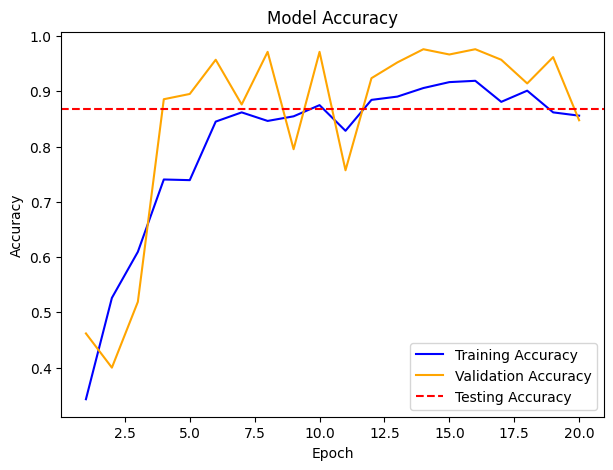

In [22]:
# Calculate manual accuracy
manual_accuracy = accuracy_score(true_classes, predicted_classes)
print(f"Manual Accuracy: {manual_accuracy:.2f}")

# Generate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

# Plot Accuracy
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(7, 5))  # Adjust figure size
plt.plot(epochs, history.history['accuracy'], 'b-', label='Training Accuracy')  # Blue solid line
plt.plot(epochs, history.history['val_accuracy'], 'orange', label='Validation Accuracy')  # Orange solid line
plt.axhline(y=test_accuracy, color='red', linestyle='dashed', label='Testing Accuracy')  # Red dashed line
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

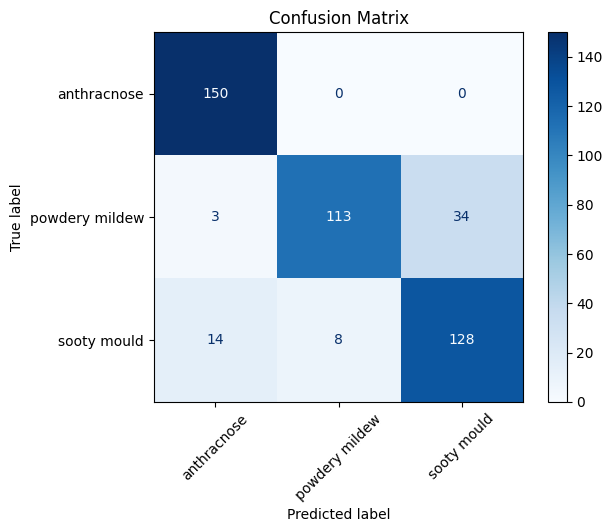

In [23]:
# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


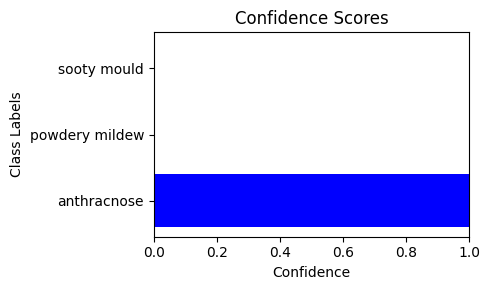

In [25]:
# Function to classify an uploaded image
def classify_image():
    # Open file dialog to select an image
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    if not file_path:
        print("No file selected.")
        return

    # Extract actual class (assuming folder structure includes the class name)
    actual_class = os.path.basename(os.path.dirname(file_path))  # Folder name is the class label

    # Load the selected image
    image = load_img(file_path, target_size=(128, 128))
    image_array = img_to_array(image)

    # Preprocess the image
    preprocessed_image = image_array / 255.0  # Normalize pixel values
    preprocessed_image_expanded = np.expand_dims(preprocessed_image, axis=0)  # Add batch dimension

    # Predict the class
    predictions = best_model.predict(preprocessed_image_expanded)
    predicted_class_index = np.argmax(predictions)
    confidence_scores = predictions.flatten()

    # Map predicted index to class label
    index_to_label = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class_name = index_to_label[predicted_class_index]

    # Display the images and results
    display_results(image, preprocessed_image, predicted_class_name, actual_class, confidence_scores, index_to_label)

def display_results(original, preprocessed, predicted_label, actual_label, confidence_scores, index_to_label):
    # Create a new window for displaying results
    result_window = tk.Toplevel()
    result_window.title("Classification Results")

    # Convert images to PIL format for display in Tkinter
    original_img = Image.fromarray(np.uint8(original))
    preprocessed_img = Image.fromarray((preprocessed * 255).astype('uint8'))

    original_img_tk = ImageTk.PhotoImage(original_img.resize((150, 150)))
    preprocessed_img_tk = ImageTk.PhotoImage(preprocessed_img.resize((150, 150)))

    # Display images in the first row
    tk.Label(result_window, text="Original Image").grid(row=0, column=0, padx=10, pady=5)
    tk.Label(result_window, text="Preprocessed Image").grid(row=0, column=1, padx=10, pady=5)

    tk.Label(result_window, image=original_img_tk).grid(row=1, column=0, padx=10, pady=5)
    tk.Label(result_window, image=preprocessed_img_tk).grid(row=1, column=1, padx=10, pady=5)

    # Store images in memory to prevent garbage collection
    result_window.original_img_tk = original_img_tk
    result_window.preprocessed_img_tk = preprocessed_img_tk

    # Display predicted and actual labels
    tk.Label(result_window, text=f"Predicted: {predicted_label}", font=("Arial", 14)).grid(row=2, column=0, columnspan=2, pady=5)
    tk.Label(result_window, text=f"Actual: {actual_label}", font=("Arial", 14), fg="green").grid(row=3, column=0, columnspan=2, pady=5)

    # Create a bar chart for confidence scores
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.barh(list(index_to_label.values()), confidence_scores, color='blue')
    ax.set_xlim(0, 1)
    ax.set_title("Confidence Scores")
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Class Labels")
    plt.tight_layout()

    # Convert the bar chart to a Tkinter-compatible image
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    bar_chart_img = Image.open(buf)
    bar_chart_tk = ImageTk.PhotoImage(bar_chart_img)

    # Display the bar chart
    tk.Label(result_window, image=bar_chart_tk).grid(row=4, column=0, columnspan=2, pady=10)
    result_window.bar_chart_tk = bar_chart_tk  # Store chart in memory
    buf.close()

# GUI for uploading and classifying images
root = tk.Tk()
root.title("Banana Ripeness Classifier")

# Add a button to classify an image
upload_btn = tk.Button(root, text="Upload Image for Classification", command=classify_image, font=("Arial", 14), padx=20, pady=10)
upload_btn.pack(pady=20)

# Run the GUI
root.mainloop()

In [ ]:
import tkinter as tk
from tkinter import filedialog
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageTk
import os
import cv2  # Import OpenCV for CLAHE

# Function to classify an uploaded image
def classify_image():
    # Open file dialog to select an image
    file_path = filedialog.askopenfilename(filetypes=[("Image Files", "*.jpg;*.jpeg;*.png")])
    if not file_path:
        print("No file selected.")
        return

    # Extract actual class (assuming folder structure includes the class name)
    actual_class = os.path.basename(os.path.dirname(file_path))  # Folder name is the class label

    # Load the selected image
    image = load_img(file_path, target_size=(128, 128))
    image_array = img_to_array(image)

    # Preprocess the image (Normalize pixel values)
    preprocessed_image = image_array / 255.0

    # Apply CLAHE preprocessing
    clahe_image = clahe_preprocess(image_array)

    # Expand dimensions for model prediction
    preprocessed_image_expanded = np.expand_dims(preprocessed_image, axis=0)

    # Predict the class (Ensure `cnn` and `train_generator.class_indices` are defined)
    predictions = cnn.predict(preprocessed_image_expanded)
    predicted_class_index = np.argmax(predictions)
    confidence_scores = predictions.flatten()

    # Map predicted index to class label
    index_to_label = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class_name = index_to_label[predicted_class_index]

    # Display the images and results
    display_results(image, preprocessed_image, clahe_image, predicted_class_name, actual_class, confidence_scores, index_to_label)

# Function to apply CLAHE preprocessing
def clahe_preprocess(image_array):
    # Convert to LAB color space
    lab = cv2.cvtColor(image_array.astype(np.uint8), cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)

    # Merge the channels and convert back to RGB
    lab = cv2.merge([l, a, b])
    clahe_image = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)
    return clahe_image

def display_results(original, preprocessed, clahe_image, predicted_label, actual_label, confidence_scores, index_to_label):
    # Create a new window for displaying results
    result_window = tk.Toplevel()
    result_window.title("Classification Results")

    # Convert images to PIL format for display in Tkinter
    original_img = Image.fromarray(np.uint8(original))
    preprocessed_img = Image.fromarray((preprocessed * 255).astype('uint8'))
    clahe_img = Image.fromarray(clahe_image.astype('uint8'))

    original_img_tk = ImageTk.PhotoImage(original_img.resize((150, 150)))
    preprocessed_img_tk = ImageTk.PhotoImage(preprocessed_img.resize((150, 150)))
    clahe_img_tk = ImageTk.PhotoImage(clahe_img.resize((150, 150)))

    # Display images in the first row
    tk.Label(result_window, text="Original Image").grid(row=0, column=0, padx=10, pady=5)
    tk.Label(result_window, text="Preprocessed Image").grid(row=0, column=1, padx=10, pady=5)
    tk.Label(result_window, text="CLAHE Image").grid(row=0, column=2, padx=10, pady=5)

    tk.Label(result_window, image=original_img_tk).grid(row=1, column=0, padx=10, pady=5)
    tk.Label(result_window, image=preprocessed_img_tk).grid(row=1, column=1, padx=10, pady=5)
    tk.Label(result_window, image=clahe_img_tk).grid(row=1, column=2, padx=10, pady=5)

    # Store images in memory to prevent garbage collection
    result_window.original_img_tk = original_img_tk
    result_window.preprocessed_img_tk = preprocessed_img_tk
    result_window.clahe_img_tk = clahe_img_tk

    # Display predicted and actual labels
    tk.Label(result_window, text=f"Predicted: {predicted_label}", font=("Arial", 14)).grid(row=2, column=0, columnspan=3, pady=5)
    tk.Label(result_window, text=f"Actual: {actual_label}", font=("Arial", 14), fg="green").grid(row=3, column=0, columnspan=3, pady=5)

    # Create a bar chart for confidence scores
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.barh(list(index_to_label.values()), confidence_scores, color='blue')
    ax.set_xlim(0, 1)
    ax.set_title("Confidence Scores")
    ax.set_xlabel("Confidence")
    ax.set_ylabel("Class Labels")
    plt.tight_layout()

    # Convert the bar chart to a Tkinter-compatible image
    from io import BytesIO
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    bar_chart_img = Image.open(buf)
    bar_chart_tk = ImageTk.PhotoImage(bar_chart_img)

    # Display the bar chart
    tk.Label(result_window, image=bar_chart_tk).grid(row=4, column=0, columnspan=3, pady=10)
    result_window.bar_chart_tk = bar_chart_tk  # Store chart in memory
    buf.close()

# GUI for uploading and classifying images
root = tk.Tk()
root.title("Mango Leaf Disease Classifier")

# Add a button to classify an image
upload_btn = tk.Button(root, text="Upload Image for Classification", command=classify_image, font=("Arial", 14), padx=20, pady=10)
upload_btn.pack(pady=20)

# Run the GUI
root.mainloop()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
